In [1]:
import SimpleITK as sitk
import numpy as np

from glob import glob
import pandas as pd
import scipy.ndimage




luna_path = 'C:/Users/user/Downloads/pfa/'
luna_subset_path = luna_path+'dataset/'
#file_list = glob(luna_subset_path + "*.mhd")
a=luna_subset_path+'1.3.6.1.4.1.14519.5.2.1.6279.6001.100684836163890911914061745866.mhd'
b=luna_subset_path+'1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860.mhd'
file_list=[a,b]

df_node = pd.read_csv(luna_path+'CSVFILES/annotations.csv')

def get_filename(file_list, case):
    for f in file_list:
        if case in f:
            return(f)

# map file full path to each record 
df_node['file'] = df_node['seriesuid'].map(lambda file_name: get_filename(file_list, file_name))
df_node = df_node.dropna()

## Define resample method to make images isomorphic, default spacing is [1, 1, 1]mm

def resample(image, old_spacing, new_spacing=[1, 1, 1]):
    
    resize_factor = old_spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = old_spacing / real_resize_factor

    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode = 'nearest')
    
    return image, new_spacing


In [2]:

import os
import numpy
import array

def write_meta_header(filename, meta_dict):
    header = ''
    # do not use tags = meta_dict.keys() because the order of tags matters
    tags = ['ObjectType','NDims','BinaryData',
       'BinaryDataByteOrderMSB','CompressedData','CompressedDataSize',
       'TransformMatrix','Offset','CenterOfRotation',
       'AnatomicalOrientation',
       'ElementSpacing',
       'DimSize',
       'ElementType',
       'ElementDataFile',
       'Comment','SeriesDescription','AcquisitionDate','AcquisitionTime','StudyDate','StudyTime']
    for tag in tags:
        if tag in meta_dict.keys():
            header += '%s = %s\n'%(tag,meta_dict[tag])
    f = open(filename,'w')
    f.write(header)
    f.close()
    
def dump_raw_data(filename, data):
    """ Write the data into a raw format file. Big endian is always used. """
    #Begin 3D fix
    data=data.reshape([data.shape[0],data.shape[1]*data.shape[2]])
    #End 3D fix
    rawfile = open(filename,'wb')
    a = array.array('f')
    for o in data:
        a.fromlist(list(o))
    #if is_little_endian():
    #    a.byteswap()
    a.tofile(rawfile)
    rawfile.close()
    
def write_mhd_file(mhdfile, data, dsize):
    assert(mhdfile[-4:]=='.mhd')
    meta_dict = {}
    meta_dict['ObjectType'] = 'Image'
    meta_dict['BinaryData'] = 'True'
    meta_dict['BinaryDataByteOrderMSB'] = 'False'
    meta_dict['ElementType'] = 'MET_FLOAT'
    meta_dict['NDims'] = str(len(dsize))
    meta_dict['DimSize'] = ' '.join([str(i) for i in dsize])
    meta_dict['ElementDataFile'] = os.path.split(mhdfile)[1].replace('.mhd','.raw')
    write_meta_header(mhdfile, meta_dict)

    pwd = os.path.split(mhdfile)[0]
    if pwd:
        data_file = pwd +'/' + meta_dict['ElementDataFile']
    else:
        data_file = meta_dict['ElementDataFile']

    dump_raw_data(data_file, data)
    
def save_nodule(nodule_crop, name_index):
    np.save('C:/Users/user/Downloads/pfa/3d visualization/fichier mhd npy raw/'+ str(name_index) + '.npy', nodule_crop)
    write_mhd_file('C:/Users/user/Downloads/pfa/3d visualization/fichier mhd npy raw/'+ str(name_index) + '.mhd', nodule_crop, nodule_crop.shape[::-1])

In [3]:
## Collect patients with nodule and crop the nodule
# In this code snippet, the cropped nodule is a [19, 19, 19] volume with [1, 1, 1]mm spacing.
# Learned from Jonathan Mulholland and Aaron Sander, Booz Allen Hamilton
# https://www.kaggle.com/c/data-science-bowl-2017#tutorial

# Change the number in the next line to process more
from math import *

for patient in file_list :
    print(patient)
    
    # Check whether this patient has nodule or not
    if patient not in df_node.file.values:
        print('Patient ' + patient + ' Not exist!')
        continue
    print('patient'+patient+' exist')
    patient_nodules = df_node[df_node.file == patient]
    
    full_image_info = sitk.ReadImage(patient)
    full_scan = sitk.GetArrayFromImage(full_image_info)
    
    origin = np.array(full_image_info.GetOrigin())[::-1] # get [z, y, x] origin
    old_spacing = np.array(full_image_info.GetSpacing())[::-1] # get [z, y, x] spacing
    
    image, new_spacing = resample(full_scan, old_spacing)
    
    print('Resample Done')
    

    for index, nodule in patient_nodules.iterrows():
        nodule_center = np.array([nodule.coordZ, nodule.coordY, nodule.coordX]) 
        # Attention: Z, Y, X
        nodule_diam = nodule.diameter_mm
        v_center = np.rint( (nodule_center - origin) / new_spacing )
        v_center = np.array(v_center, dtype=int)

#         print(v_center)
        
        nodule_size = ceil(nodule_diam/2) # This will give you the volume length 
        window_size=9
        zyx_1 = v_center - max(window_size,nodule_size) # Attention: Z, Y, X
        zyx_2 = v_center + max(window_size,nodule_size) +1

#         print('Crop range: ')
        print(zyx_1)
        print(zyx_2)

       
        img_crop = image[ zyx_1[0]:zyx_2[0], zyx_1[1]:zyx_2[1], zyx_1[2]:zyx_2[2] ]
        
        #img_crop.resize((img_crop.shape[0]*2,img_crop.shape[1]*2,img_crop.shape[2]))
        #img_crop = scipy.ndimage.interpolation.zoom(img_crop, [2,2,2], mode = 'nearest')
        
        print('name_file : ',index)
        # save the nodule 
        save_nodule(img_crop, index)

    print('Done for this patient!\n\n')
print('Done for all!')





C:/Users/user/Downloads/pfa/dataset/1.3.6.1.4.1.14519.5.2.1.6279.6001.100684836163890911914061745866.mhd
Patient C:/Users/user/Downloads/pfa/dataset/1.3.6.1.4.1.14519.5.2.1.6279.6001.100684836163890911914061745866.mhd Not exist!
C:/Users/user/Downloads/pfa/dataset/1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860.mhd
patientC:/Users/user/Downloads/pfa/dataset/1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860.mhd exist
Resample Done
[131 127  20]
[150 146  39]
name_file :  0
[202  91 252]
[221 110 271]
name_file :  1
Done for this patient!


Done for all!


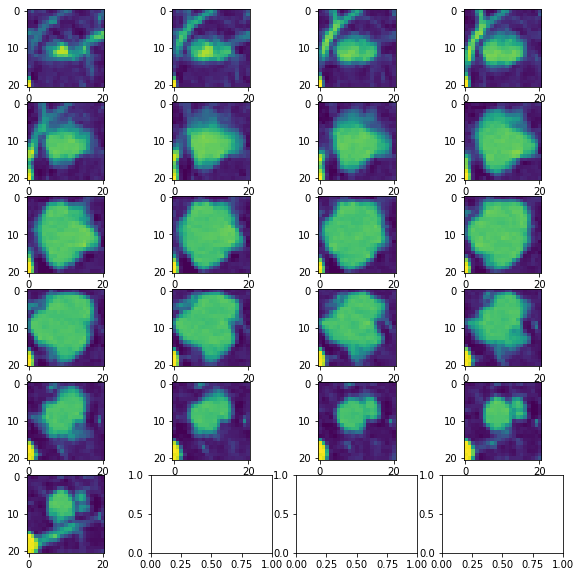

In [3]:
## Plot volume in 2D

import numpy as np
from matplotlib import pyplot as plt

def plot_nodule(nodule_crop):
    
    
    f, plots = plt.subplots(int(nodule_crop.shape[0]/4)+1, 4, figsize=(10, 10))
    
    for z_ in range(nodule_crop.shape[0]): 
        plots[int(z_/4), z_ % 4].imshow(nodule_crop[z_,:,:])
    
    # The last subplot has no image because there are only 19 images.
    plt.show()
    
# Plot one example
img_crop = np.load('C:/Users/user/Downloads/pfa/3d visualization/fichier mhd npy raw/5.npy')
plot_nodule(img_crop)

In [5]:
import numpy as np
from skimage import measure, feature
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def plot_3d(image, threshold=0):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    # p = p[:,:,::-1]
    
    verts,faces = measure.marching_cubes_classic(p) # try without classic later
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces],alpha=0.5)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    
    
    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

In [ ]:
path='C:/Users/user/Downloads/pfa/3d visualization/fichier mhd npy raw/5.mhd'
data =sitk.ReadImage(path)
print(data)
spacing = data.GetSpacing()
print('spacing: ', spacing)
scan = sitk.GetArrayFromImage(data)

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:13: FutureWarning: marching_cubes_classic is deprecated in favor of marching_cubes with `method='_lorensen'` to apply Lorensen et al. algorithm. marching_cubes_classic will be removed in version 0.19
  del sys.path[0]


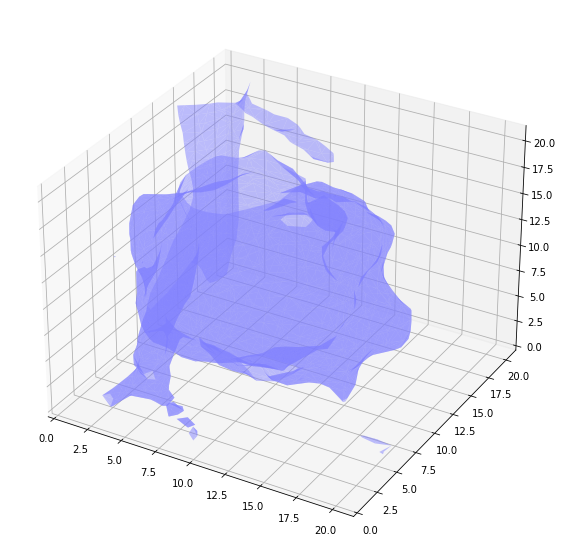

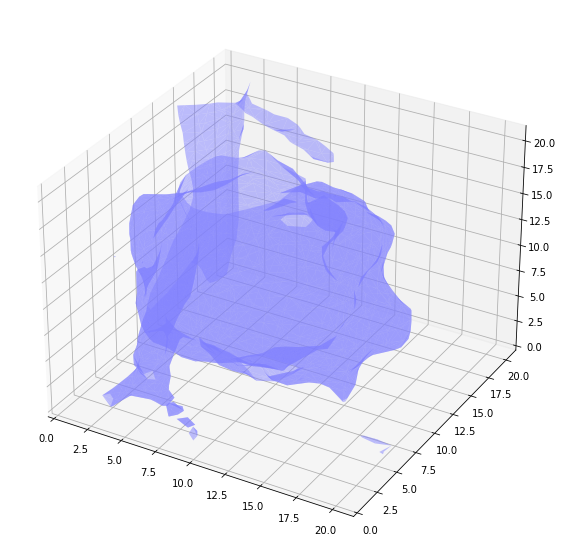

In [7]:
plot_3d(scan)
plot_3d(scan,150)